In [135]:
import sys
import os
os.environ['PROJ_DATA'] = "/pscratch/sd/p/plutzner/proj_data"
import xarray as xr
import torch
import torchinfo
import random
import numpy as np
import importlib as imp
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cartopy.crs as ccrs
import json
import pickle
import gzip
import scipy
from scipy import stats
#import matplotlib.colors as mcolorsxx

# %load_ext autoreload
# %autoreload 2
import utils
import utils.filemethods as filemethods
import databuilder.data_loader as data_loader
from databuilder.data_loader import universaldataloader
import databuilder.data_generator as data_generator
from databuilder.data_generator import ClimateData
import model.loss as module_loss
import model.metric as module_metric
from databuilder.data_generator import multi_input_data_organizer
from model.metric import iqr_basic
import databuilder.data_loader as data_loader
from utils.filemethods import open_data_file
from trainer.trainer import Trainer
from model.build_model import TorchModel
from base.base_model import BaseModel
from utils import utils
from shash.shash_torch import Shash
import analysis.calc_climatology as calc_climatology
from analysis import analysis_metrics
from utils.utils import filter_months
import analysis
from analysis import CRPS
from analysis import ENSO_indices_calculator

print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")
print(f"pytorch version = {torch.__version__}")


python version = 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0]
numpy version = 1.26.4
xarray version = 2024.5.0
pytorch version = 2.0.0.post104


In [136]:
# Open exp015 shash predictions and CRPS scores: 
config = utils.get_config("exp016")
seed = config["seed_list"][0]

# Open Model Outputs
model_output = str(config["perlmutter_output_dir"]) + str(config["expname"]) + '/' + str(config["expname"]) + '_network_SHASH_parameters.pkl'
output = analysis_metrics.load_pickle(model_output)
print(f"output shape: {output.shape}")

CRPS_network = analysis_metrics.load_pickle(str(config["perlmutter_output_dir"]) + str(config["expname"]) + "/" + str(config["expname"]) + "CRPS_network_values.pkl")
CRPS_climatology = analysis_metrics.load_pickle(str(config["perlmutter_output_dir"]) + str(config["expname"]) + "/" + str(config["expname"]) + "CRPS_climatology_values.pkl")


output shape: (14753, 4)


In [137]:
# Open Target Data
s_dict_savename3 = str(config["perlmutter_inputs_dir"]) + str(config["expname"]) + "_d_test.pkl"
target = universaldataloader(s_dict_savename3, config, target_only = True, repackage = False)
print(f"UDL target shape: {target.shape}")

Opened pickle file: /pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp016_d_test.pkl
UDL target shape: (14753,)


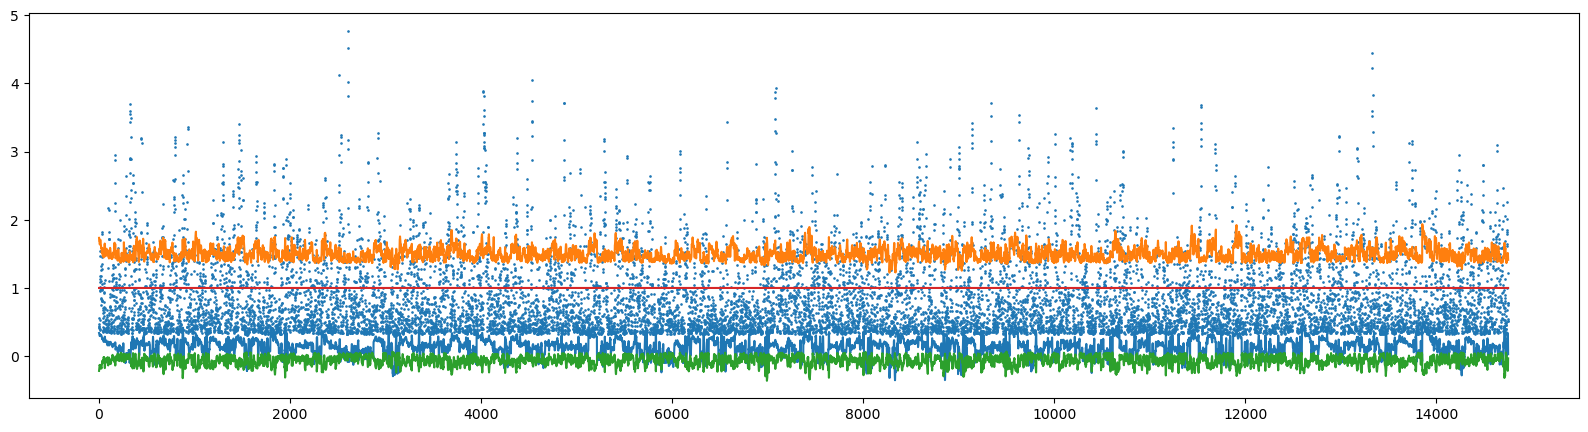

In [138]:
plt.figure(figsize = (20, 5))
plt.scatter(range(len(CRPS_network)), CRPS_network, s = 0.8)
plt.plot(output[:, 0])
plt.plot(output[:, 1])
plt.plot(output[:, 2])
plt.plot(output[:, 3])

/global/common/software/m4620/conda/envs/env-torch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/common/software/m4620/conda/envs/env-torch/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


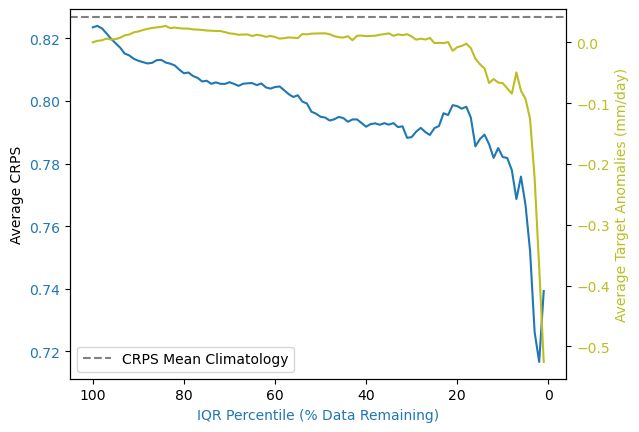

In [139]:
sample_index = analysis_metrics.discard_plot(output, target, CRPS_network, CRPS_climatology, config, target_type = 'anomalous')

/global/common/software/m4620/conda/envs/env-torch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/common/software/m4620/conda/envs/env-torch/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


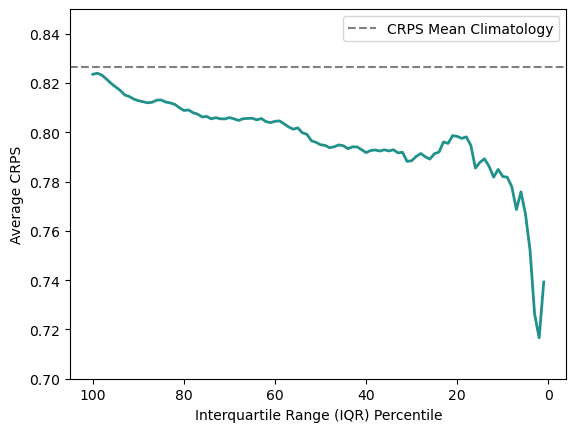

In [140]:
iqr = iqr_basic(output)

percentiles = np.linspace(100, 0, 101)

avg_crps = []
avg_target = []
sample_index = np.zeros((len(target), len(percentiles)))
for ip, p in enumerate(percentiles):
    avg_crps.append(np.mean(CRPS_network[iqr < np.percentile(iqr, p)]))
    avg_target.append(np.mean(target[iqr < np.percentile(iqr, p)]))
    # capture the index (out of total) for all the samples in each bin
    indices = np.where(iqr < np.percentile(iqr, p))[0]
    sample_index[:len(indices), ip] = indices

color = '#21918c'
fig, ax1 = plt.subplots()
plt.gca().invert_xaxis()
ax1.set_ylabel('Average CRPS')
ax1.set_xlabel('Interquartile Range (IQR) Percentile')
ax1.plot(percentiles, avg_crps, color=color, linewidth = 2)
ax1.tick_params(axis='y')
ax1.axhline(y=CRPS_climatology.mean(), color='grey', linestyle='--', label='CRPS Mean Climatology')
ax1.set_ylim([0.7, 0.85])
# ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# legend
ax1.legend(loc = 'upper right')

plt.savefig('/pscratch/sd/p/plutzner/E3SM/saved/figures/exp016/AMS_discardplot.png', transparent = True, format = 'png', dpi = 350)

(14753, 101)
148
Opened pickle file: /pscratch/sd/p/plutzner/E3SM/bigdata/presaved/exp016_d_train.pkl
UDL climatology shape (14753,)
Climatologial Mean = <xarray.DataArray 'PRECT' ()> Size: 8B
array(0.00247931)


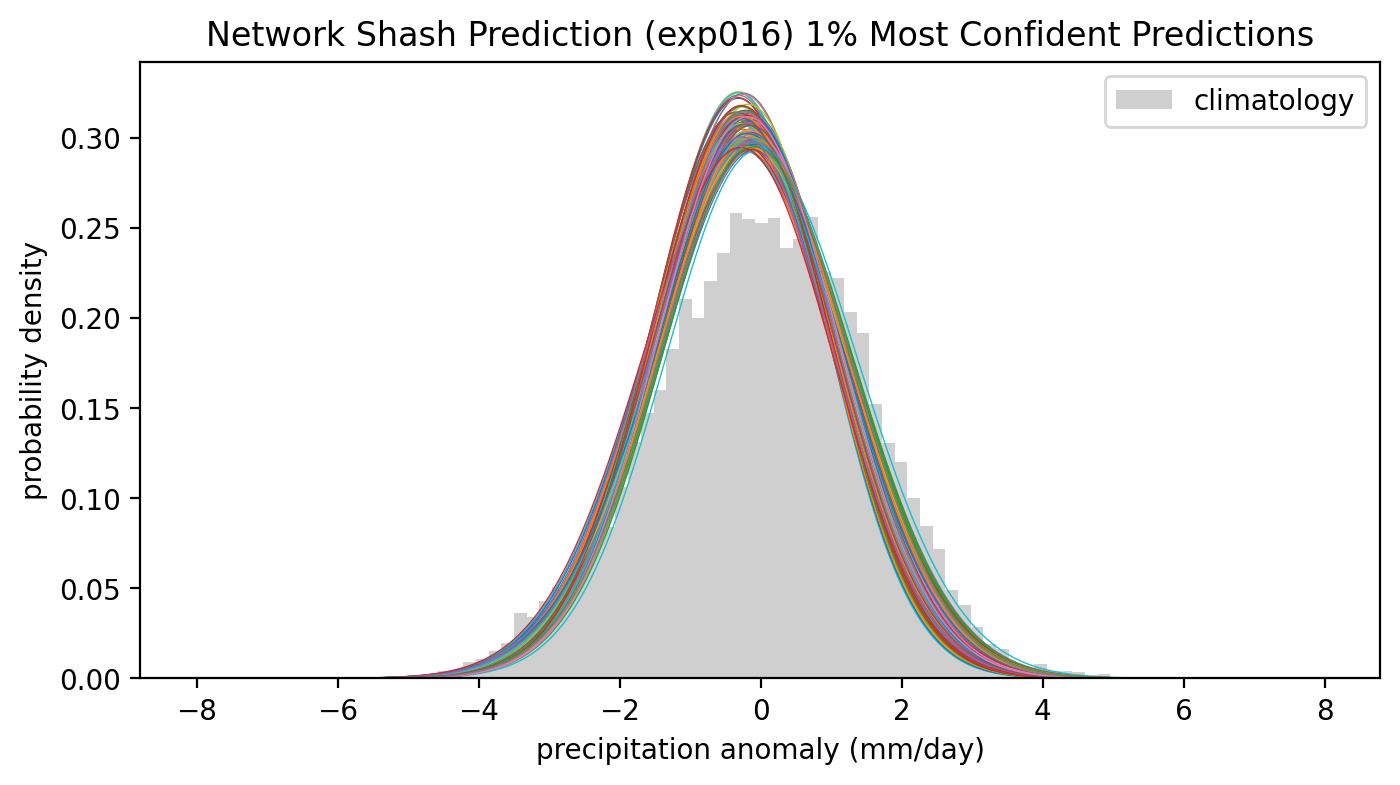

In [141]:
print(sample_index.shape)

conf1 = sample_index[:, 99]
# Filter out zeros to keep only the nonzero values: 443 predictions
nonzero_conf1 = conf1[conf1 != 0].astype(int)
print(len(nonzero_conf1))

# Open Climatology Data: TRAINING DATA
climatology_filename = str(config["perlmutter_inputs_dir"]) + str(config["expname"]) + "_d_train.pkl"
climatology = universaldataloader(climatology_filename, config, target_only = True, repackage = False)
print(f"UDL climatology shape {climatology.shape}")

# Compare SHASH predictions to climatology histogram
x_coarse = np.arange(-8, 8, 0.18)
x_fine = np.arange(-8, 8, 0.01)

# Plot SHASH of most confident 3% of Samples which most likely align with El Nino
print(f"Climatologial Mean = {np.mean(climatology)}")

dist = Shash(output[nonzero_conf1, :])
p = dist.prob(x_fine).numpy()

plt.figure(figsize=(8, 4), dpi=200)
plt.hist(
    climatology, x_coarse, density=True, color="silver", alpha=0.75, label="climatology"
)

plt.plot(x_fine, p, linewidth = 0.5 ) #label = samples
plt.xlabel("precipitation anomaly (mm/day)")
plt.ylabel("probability density")
plt.title("Network Shash Prediction (" + str(config["expname"] + ") 1% Most Confident Predictions"))
# plt.axvline(valset[:len(output)], color='r', linestyle='dashed', linewidth=1)
plt.legend()
plt.savefig(str(config["perlmutter_figure_dir"]) + str(config["expname"]) + '/' + str(config["expname"]) + '_predictions_w_climatology.png', format='png', bbox_inches ='tight', dpi = 300)
# plt.xlim([-10, 12])

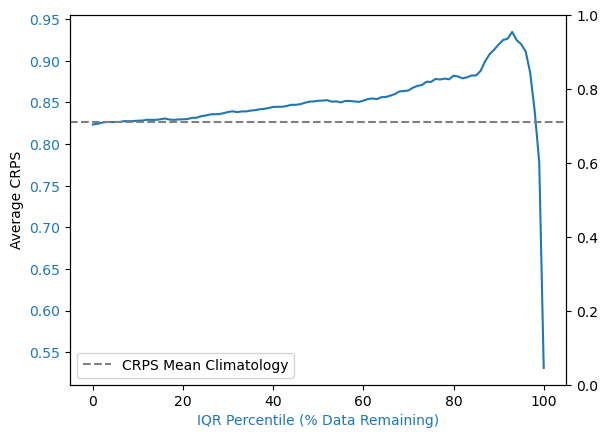

In [142]:
iqr = iqr_basic(output)

percentiles = np.linspace(0, 100, 101)

avg_crps = []
avg_target = []
sample_index_WIDE = np.zeros((len(target), len(percentiles)))
for ip, p in enumerate(percentiles):
    avg_crps.append(np.mean(CRPS_network[iqr >= np.percentile(iqr, p)]))
    avg_target.append(np.mean(target[iqr >= np.percentile(iqr, p)]))
    # capture the index (out of total) for all the samples in each bin
    indices = np.where(iqr > np.percentile(iqr, p))[0]
    sample_index_WIDE[:len(indices), ip] = indices

color = 'tab:blue'
fig, ax1 = plt.subplots()
# plt.gca().invert_xaxis()
ax1.set_ylabel('Average CRPS')
ax1.set_xlabel('IQR Percentile (% Data Remaining)', color=color)
ax1.plot(percentiles, avg_crps, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.axhline(y=CRPS_climatology.mean(), color='grey', linestyle='--', label='CRPS Mean Climatology')
# ax1.set_ylim([1.05, 1.205])
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
# legend
ax1.legend(loc = 'lower left')

[[-0.31848606  1.2317365   0.01359061  1.        ]
 [-0.31706604  1.2269295   0.01664101  1.        ]
 [-0.31685156  1.2382016   0.02374653  1.        ]
 [-0.3166823   1.2246665   0.0141692   1.        ]]


<Figure size 640x480 with 0 Axes>

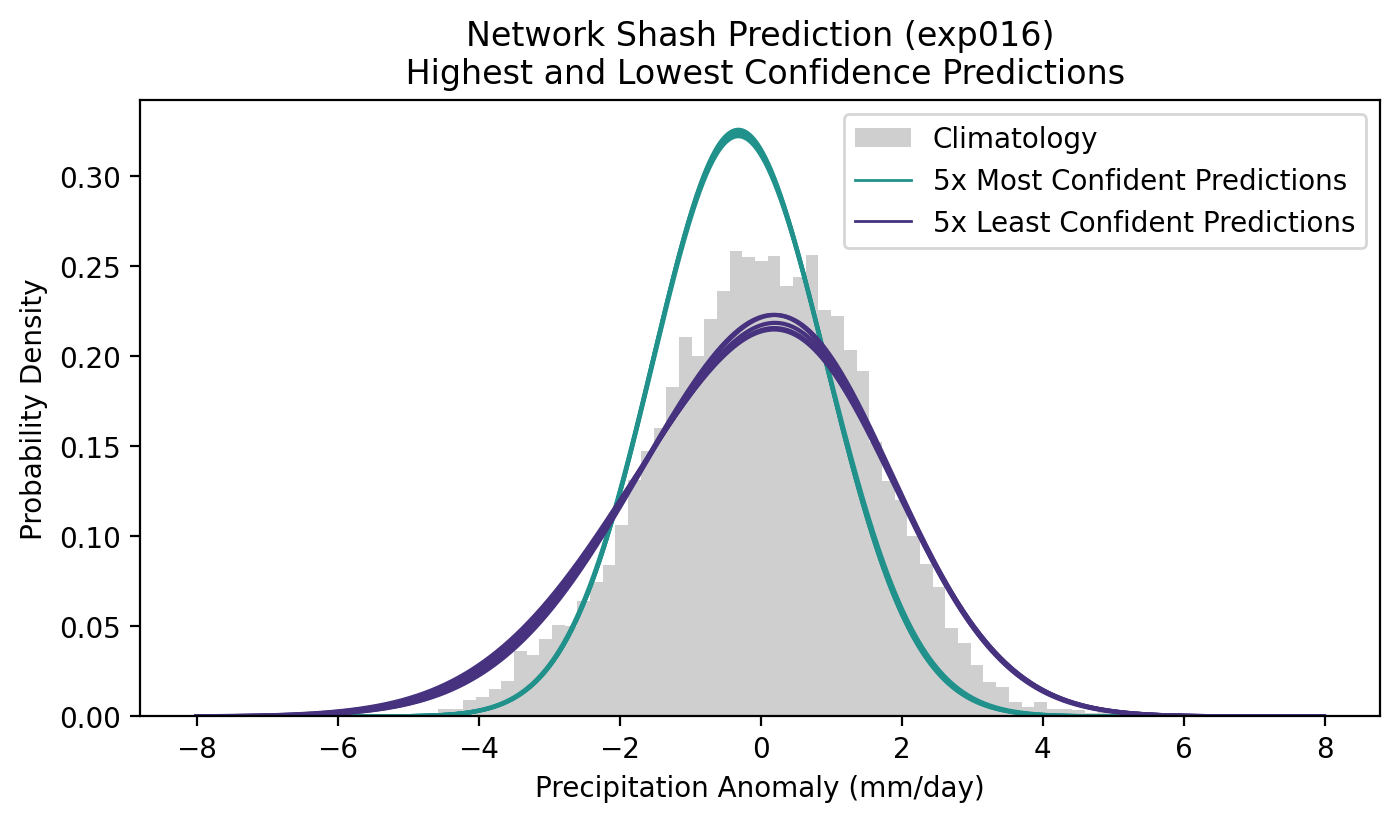

In [143]:
plt.figure()

# MOST CONFIDENT SAMPLES: ---------------------
# Extract the specific values from the output
conf1_SHASHparams = output[nonzero_conf1, :]

mu_conf1 = conf1_SHASHparams[:, 0]

# Get the indices of the 5 lowest values
lowest_mu_indices = mu_conf1.argsort()[:10]

# find the indices of the lowest values in context of the full output dataset: (which sample numbers are these)
i_specialshash = nonzero_conf1[lowest_mu_indices]

# Map these back to the original indices in `nonzero_conf3`
most_unique_samples = conf1_SHASHparams[lowest_mu_indices, :]

top5_shashs = most_unique_samples[5:9]
print(top5_shashs)

# LEAST CONFIDENT SAMPLES ----------------------
conf99 = sample_index_WIDE[:, 99]
nonzero_conf99 = conf99[conf99 != 0].astype(int)

conf99_SHASHparams = output[nonzero_conf99, :]
mu_conf99 = conf99_SHASHparams[:, 0]

# Get the indices of the 5 lowest values
mu_indices99 = mu_conf99.argsort()[:5]

# find the indices of the lowest values in context of the full output dataset: (which sample numbers are these)
i_specialshash99 = nonzero_conf99[mu_indices99]

# Map these back to the original indices in `nonzero_conf3`
least_conf_shashes = conf99_SHASHparams[mu_indices99, :]

# top5_shashs = most_unique_samples[5:9]
# print(top5_shashs)

# DISTS ==================
dist = Shash(top5_shashs)
p_top5 = dist.prob(x_fine).numpy()

dist = Shash(least_conf_shashes)
p_bot5 = dist.prob(x_fine).numpy()

# -------------------------

plt.figure(figsize=(8, 4), dpi=200)
plt.hist(
    climatology, x_coarse, density=True, color="silver", alpha=0.75, label="Climatology"
)

plt.plot(x_fine, p_top5, linewidth = 1.5, color = '#21918c')
plt.plot(x_fine, p_top5[:, 0], linewidth = 1, color = '#21918c', label = '5x Most Confident Predictions') #label = samples
plt.plot(x_fine, p_bot5, linewidth = 1.5, color = '#46327e')
plt.plot(x_fine, p_bot5[:, 0], linewidth = 1, color = '#46327e', label = '5x Least Confident Predictions')
# plt.plot(x_fine, p[:, 5:9], color = 'red')
plt.xlabel("Precipitation Anomaly (mm/day)")
plt.ylabel("Probability Density")
plt.title("Network Shash Prediction (" + str(config["expname"] + ")\n Highest and Lowest Confidence Predictions"))
# plt.axvline(valset[:len(output)], color='r', linestyle='dashed', linewidth=1)
plt.legend()
plt.savefig(str(config["perlmutter_figure_dir"]) + str(config["expname"]) + '/' + str(config["expname"]) + '_predictions_w_climatology.png', format='png', transparent = True, bbox_inches ='tight', dpi = 350)
# plt.xlim([-10, 12])